# Multicanonical Sampling (MUCA)

In basic multicanonical sampling we attempt to bias our sampling of each energy _macrostate_ (i.e. histogram bin) such that all energies are visited with equal probability, i.e. a "flat" histogram. We can then adjust the weight of generated samples to reconstruct statistics at any temperature of interest. 

The probability of visiting a particular energy is;

$$ P(\left(U\right) = g\left(U\right) \frac{ \exp{[-\beta U]} }{Z} $$

where $g(U)$ is the density of states in energy, i.e. the number of microstates which have than energy. In physics we're more used to thinking of the logarithm of this quantity

$$ S(U) = k_B \ln{g\left(U\right)} $$

where $S$ is known as the _entropy_ (strictly speaking the Boltzmann entropy). 

To produce a flat histogram we augment the energy $U$ with a bias $V(U)$ such that the probability of visiting energy $U$ at temperature $T$ is now:

$$ \tilde{P}(\left(U\right) = g(U) \frac{  \exp{[-\beta ( U + V(U) ]} }{Z} $$

If we choose $V(U) = -k_B T \ln{P(\left(U\right)}$ then conveniently $\tilde{P}(U)=1$ and we'll acheive uniform sampling in energy as desired. 

[As an aside, the quanity $A(U) = k_B T \ln{P(\left(U\right)}$ defines the Helmholtz _free_ energy as a function of $U$ and hence in other contexts (chemistry) variations on this theme are referred to as free energy calculation. In such contexts we might be biasing to produce flat histograms in some observable other than energy, but only obtain statistics for a single temperature. See metadynamics, umbrella sampling etc.]

Unfortunately we don't know $P(\left(U\right)$ _a priori_ and so need an iterative procedure. For example:

1. Start with $V(U)=0$ for all $U$ and run a standard canonical Monte Carlo simulation as in the last workbook.
2. Use the resulting $P(\left(U\right)$ to estimate the optimal $V(U)$. This will be a poor estimate for regions of $U$ that are so unprobable at the current $T$ that we have sampled poorly there.
3. Run a new MC simulation with the current bias $V(U)$. Construct an improved estimate of $P(U)$ from the resulting $\tilde{P}\left(U\right)$ via _histogram reweighting_. 

We repeat steps 2 and 3 until we produce a histogram which is close to flat, and then run a final simulation sampling all quanitities of interest which can then be reweighted to give statistics at any temperature of interest. 

The reweighting at step 3 is straightforward. We've generated $\tilde{P}\left(U\right)$ by counting all samples that land in each histogram bin with a weight of 1. Instead we count each sample $i$ with weight $w_i = \exp{[\beta V(U_i)]}$ where $U_i$ is the energy of sample $i$ recognising that;

$$ P(U_i) = \tilde{P}(U_i) w_i $$

to within a normalisation factor of no importance. 

The following implements this procedure for our toy bead and spring polymer model.

## Demonstration on our simple bead and spring "polymer" model

See `Basic_MMC.ipynb` and `polymer.py` for details of the model.


### Import packages and create some binning functions functions

In [1]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [9]:
def bin_index(x, bin_edges):
    """Given a list of bin_edges returned from numpy.histogram, and a sampled value x, 
       return the index of the bin in which x lies. Note that np.digitize is annoying
       and I don't like it.

    Parameters:
    x (float) : sample to assign to a bin
    bin_edges : bin edges as returned from numpy.histogram 

    Returns:
    i         : index of bin in which sample lies

    """
    
    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

### Histogram unbiasing/reweighting function key to the MUCA procedure

In [41]:
def ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, run_temperature, target_temperature):
    """Given a list of energy samples aquired during an MUCA simulation at run_temperature and with bias 
       energies old_bias, return the reweighted histogram that would have been obtained with zero bias
       from a run at temperature target_temperature.

    Parameters:
    energy_samples     : list of energies sampled during MC run at run_temperature
    old_bias           : array of length len(bin_edges)-1 with the bias energy V for each energy bin
    bin_edges          : energy bin edges as returned from numpy.histogram 
    bin_width          : width of each energy bin (assumes all bins equal width)
    run_temperature    : temperature at which the energy samples were generated
    target_temperature : temperature at which the unbiased histogram is required

    Returns:
    counts, bins       : histogram counts and bins as returned from np.histogram

    """

    weights = np.zeros(len(energy_samples))

    for isamp, energy in enumerate(energy_samples):
        ibin = bin_index(energy, bin_edges)
        bias = old_bias[ibin]
        weights[isamp] = m.exp((bias+energy)/run_temperature)*m.exp(-energy/target_temperature)
        
    # Calculate the probability distribution 
    counts, bins = np.histogram(energy_samples,bins=bin_edges,weights=weights,density=True)

    return counts, bins

### Function to implement MUCA sampling on the polymer

This requires only minimal changes from that in `Basic_MCMC.ipynb`. Before and after each move we need to know the total energy of the system in order to look up the corresponding bias energy, but otherwise this proceeds exactly as before but with the move accepted based on the change in $U+V$ rather than just $U$.


In [7]:
def run_muca_sweeps(chain, bin_edges, bias, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """Performs MCMC on the provided chains for a number of "sweeps" where one sweep is on average
       an attempt to move each mobile particle once. 

    Parameters:
    chain       : polymer object to sample configurations of
    bin_edges   : energy bin edges as returned from numpy.histogram 
    bias        : array of length len(bin_edges)-1 with the bias energy V for each energy bin
    Nsweeps     : number of sweeps to perform
    max_disp    : maximum trial displacement (distance)
    temperature : temperature of heat bath the polyer is coupled to
    sample_int  : interval at which to record samples of energy and end-to-end distance 

    Returns:
    chain       : final state of the polymer
    samples     : list of tuples ( energy, end-to-end distance) of recorded samples
    ratio       : fraction of moves that were accepted

   """

    # Store inverse temperature
    beta = 1.0/temperature

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    # (New for MUCA) Establish total energy before any moves
    old_energy = chain.energy()

    # Each sweep is one trial per bead on average
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        # Make trial move and compute energy change - note we only compute the terms 
        # in the energy which depend on ibead. See polymer.py
        old_local_energy = chain.local_energy(ibead)
        chain.rpos[ibead] = chain.rpos[ibead] + disp
        new_local_energy = chain.local_energy(ibead)

        # (New for MUCA) Find bias energy V for old_energy U before move
        ibin = bin_index(old_energy, bin_edges)

        # (New for MUCA) Find bias energy V for new_energy U after move
        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)
        
        # (Modified for MUCA) only compute energy change if within limits where V is defined
        if jbin in range (0, len(bias)):

            # (Modified for MUCA add change in V into diff_energy
            old_bias = bias[ibin]
            new_bias = bias[jbin]         
            diff_energy = (new_energy + new_bias) - (old_energy + old_bias)
            
            # Accept or reject move
            if np.random.sample() < m.exp(-diff_energy*beta):
                # accepted
                acount = acount + 1.    # Accepted - increment counter
                old_energy = new_energy # (New for MUCA) update old_energy for next move
            else:
                # # Restore original chain position 
                chain.rpos[ibead] = chain.rpos[ibead] - disp
                
        else:
            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
        
        # Sample energy and end-to-end distance every sample_int sweeps
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

        ratio = acount/(Nsweeps*(chain.Nbeads-1)) 

    return chain, samples, ratio 

### Setup a simulation which uses the above to iteratively refine V

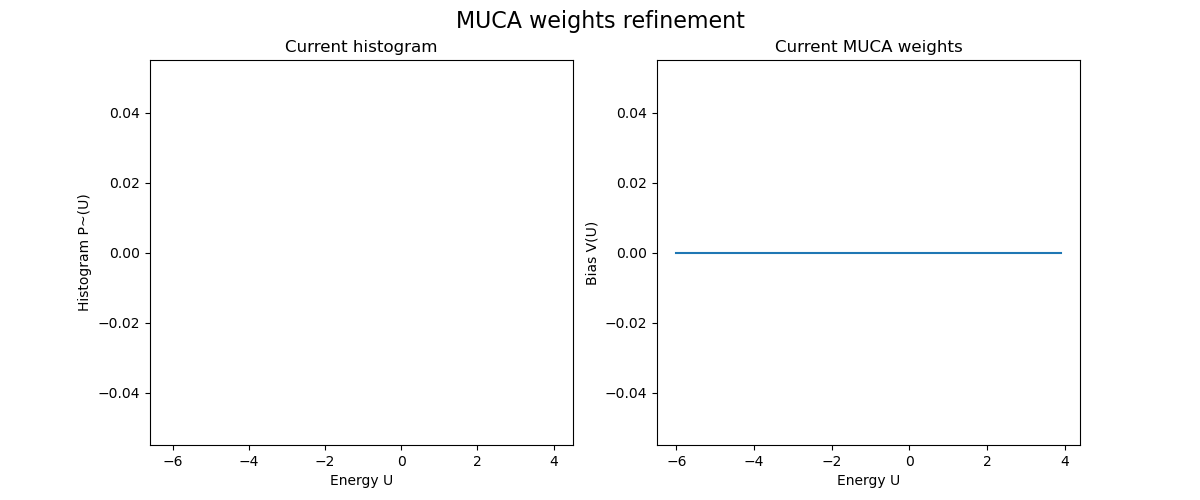

In [4]:
# Initialise muca simulation
Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Zero out the initial bias V and energy histogram P(U)
old_bias = np.zeros(len(bin_edges)-1)
muca_hist = np.zeros(len(bin_edges)-1)

# Setup some plots
%matplotlib widget

def label_muca_figure(fig, ax1, ax2):
    """ Sets up figures and axis for MUCA demonstration """

    ax1.set_xlabel('Energy U')
    ax2.set_xlabel('Energy U')
    ax1.set_ylabel('Histogram P~(U)')
    ax2.set_ylabel('Bias V(U)')
    fig.suptitle('MUCA weights refinement', fontsize=16)
    ax1.set_title('Current histogram')
    ax2.set_title('Current MUCA weights')

    return 

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
label_muca_figure(fig, ax1, ax2)
ax1.bar(bin_edges[:-1], muca_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
plt.show()

## Run `Ncycles` iterations of the MUCA procedure, improving the estimate of V at each cycle

Each cycle doesn't need to be very long and we don't need $V(U)$ to be perfect, just good enough such that we'll get good sampling accross the full range of energy.

In [12]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4       # Temperature at which to sample
Nframes = 1000   # Number of frames to run for at each MUCA cycle
Ncycles = 5      # Number of MUCA cycles to run

# Loop over MUCA cycles
for icyc in range(Ncycles):

    # I like a progress bar
    f = IntProgress(min=0, max=Nframes)
    display(f) # display the bar

    # Reset histogram for current MUCA cycle
    muca_hist = np.zeros(len(bin_edges)-1)

    # Initialise list of samples for current cycle
    samples = []

    for iframe in range(Nframes):

        chain, new_samples, ratio = run_muca_sweeps(chain, bin_edges, old_bias, max_disp=0.1, temperature=temp)
        samples += new_samples
        f.value +=1  # Increment progress bar

        energy_samples  = [ sample[0] for sample in samples ]
        counts, bins = np.histogram(energy_samples, bins=bin_edges)

        # Recreate the plot above with the current data
        ax1.cla(), ax2.cla()
        label_muca_figure(fig, ax1, ax2)
        ax1.bar(bin_edges[:-1], counts, width=bin_width,align='edge')
        ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
        plt.draw()
    
        fig.canvas.draw()
        fig.canvas.flush_events()

    print("Accepted ",round(ratio*100,2),"% of trial moves")

    # KEY STEP - create unbiased histogram via histogram reweighting
    counts, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, temp)

    # Avoid errors in early cycles by ensuring a minimum value in each histogram bin
    mincount = np.min(counts[counts > 0.0])
    counts = [ max(count,mincount) for count in counts]

    # Create bias function for next iteration
    new_bias = [ temp * m.log(count) for count in counts ]
    new_bias = np.asarray(new_bias)
    old_bias = new_bias 

    # Save the current bias. We'll use the most recent one later 
    filename = "data/muca_bias_N"+str(Nbeads)+"T"+str(temp)+"_cycle_"+str(icyc)+".txt"
    np.savetxt(filename, old_bias)

IntProgress(value=0, max=1000)

Accepted  52.5 % of trial moves


IntProgress(value=0, max=1000)

Accepted  59.5 % of trial moves


IntProgress(value=0, max=1000)

Accepted  72.0 % of trial moves


IntProgress(value=0, max=1000)

Accepted  74.17 % of trial moves


IntProgress(value=0, max=1000)

Accepted  75.67 % of trial moves


## Run a longer simulation with static $V(U)$ to obtain good quality statistics 

These are the samples we'll actually use to compute averages across different temperatures.

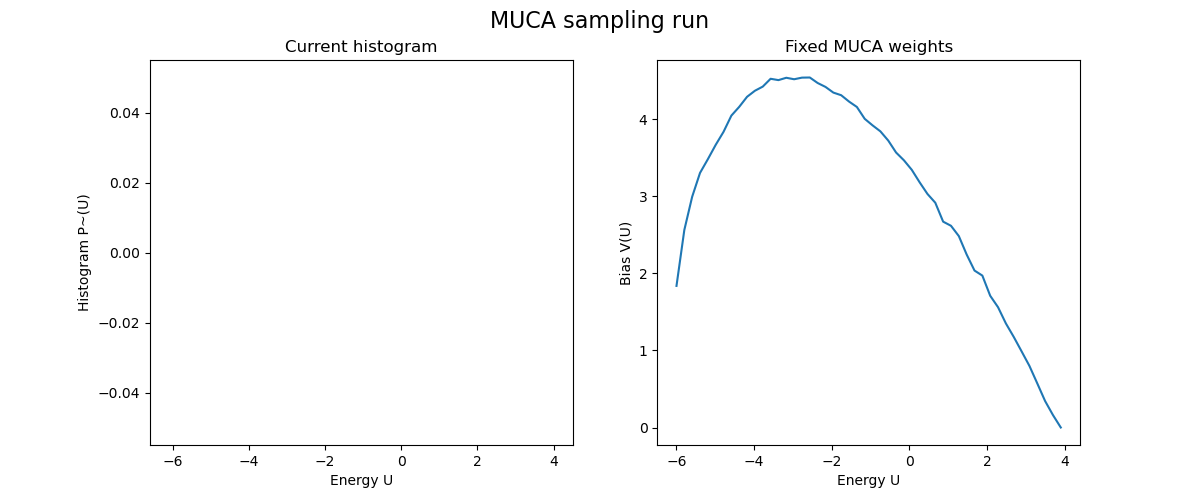

In [5]:
# Initialise muca simulation with constant weights 
Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Load MUCA weights I made earlier (comment out to use the ones generated in the above cells)
filename = 'data/muca_bias_N7T0.4_cycle_23.txt'
old_bias = np.loadtxt(filename)

# Zero histogram
muca_hist = np.zeros(len(bin_edges)-1)

# Setup some plots
%matplotlib widget
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
label_muca_figure(fig, ax1, ax2)
ax1.bar(bin_edges[:-1], muca_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
fig.suptitle('MUCA sampling run', fontsize=16)
ax2.set_title('Fixed MUCA weights')
plt.show()

Very similar to a single MUCA iteration but we don't update the bias $V(U)$

In [11]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4

Nframes = 5000 # Longer than each MUCA cycle

# I like a progress bar
f = IntProgress(min=0, max=Nframes)
display(f) # display the bar

# Reset histogram for current MUCA cycle
muca_hist = np.zeros(len(bin_edges)-1)

# Initialise list of samples for current cycle
samples = []

for iframe in range(Nframes):

    chain, new_samples, ratio = run_muca_sweeps(chain, bin_edges, old_bias, Nsweeps=100, max_disp=0.1, temperature=temp, sample_int = 100)
    samples += new_samples
    f.value +=1  # Increment progress bar

    energy_samples  = [ sample[0] for sample in samples ]
    counts, bins = np.histogram(energy_samples, bins=bin_edges)

    # update plots
    ax1.cla(), ax2.cla()
    label_muca_figure(fig, ax1, ax2)
    ax1.bar(bin_edges[:-1], counts, width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
    fig.suptitle('MUCA sampling run', fontsize=16)
    ax2.set_title('Fixed MUCA weights')
    plt.draw()
    
    fig.canvas.draw()
    fig.canvas.flush_events()

print("Accepted ",round(ratio*100,2),"% of trial moves")

filename = 'data/samples_N7T0.4_cycle_23.dat'
FILE = open(filename,"w")
np.asarray(samples).tofile(FILE)
FILE.close()


IntProgress(value=0, max=5000)

Accepted  70.17 % of trial moves


## Check that we can reconstruct the unbiased histogram

Load some samples from an unbiased (canonical) MMC simulation that was performed at a temperature $T=0.4$ and compare to that obtained from reweighting samples from the biased simulation above.

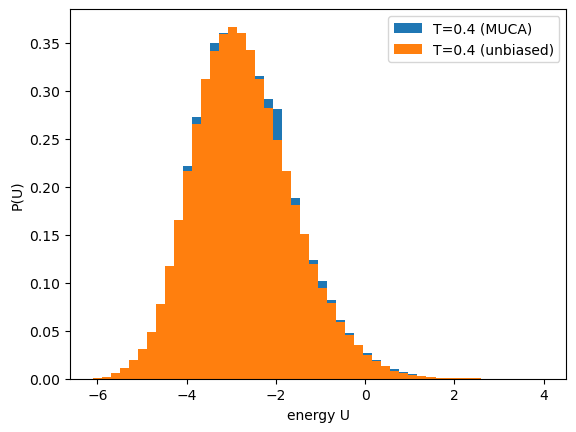

In [18]:
# Samples of energy from the above MUCA run
energy_samples  = [ sample[0] for sample in samples ]

# Samples from an ubiased MMC simulation at the same temperature
unbiased_samples = np.load("data/mcmc_N7_d2_T0.4_Nf50000.npy").tolist()
unbiased_energy_samples = [ sample[0] for sample in unbiased_samples ]
new_temp = 0.4 # Temperature at which the ubiased data was generated

# Create figure
%matplotlib inline
fig, ax = plt.subplots()
ax.cla()

# Histogram reconstructed from MUCA simulation
counts, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, new_temp)
ax.bar(bin_edges[:-1],counts,width=bin_width,align='edge', label='T=0.4 (MUCA)')

# Histogram computed from ubiased MMC simulation
counts, bins = np.histogram(unbiased_energy_samples, bins=bin_edges, density=True)
ax.bar(bin_edges[:-1], counts, width=bin_width, align='edge', label='T=0.4 (unbiased)')

ax.legend()
ax.set_xlabel('energy U')
ax.set_ylabel('P(U)')
plt.show()

## Histogram reweighting

As we've sampled the entire energy range of interest, we don't need to limit ourselves to a single temperature. If the MUCA simulation was performed at a temperature of $T_1$, inverse temperature $\beta_1=1/k_B T_1$ then we can reweight each contribution to a histogram bin with weight 

$$ w_i = \exp{[\beta_1 U_i+ V(U_i)]} \exp{[-\beta_2 U_i]} $$

to obtain the histogram for inverse temperature $\beta_2$ and hence temperature $T_2 = 1/\beta_2$. 

If the histogram in question is the energy histogram then each bar in the histogram can be just multiplied by $w_i$ for the mid-bin energy to get a good estimate for the histogram at the new temperature.

Below we use the MUCA run from above to recreate the plots of mean energy and heat capacity from the last notebook, but now we can choose any temperature (within the relevant energy range) for our plots from a single simulation.

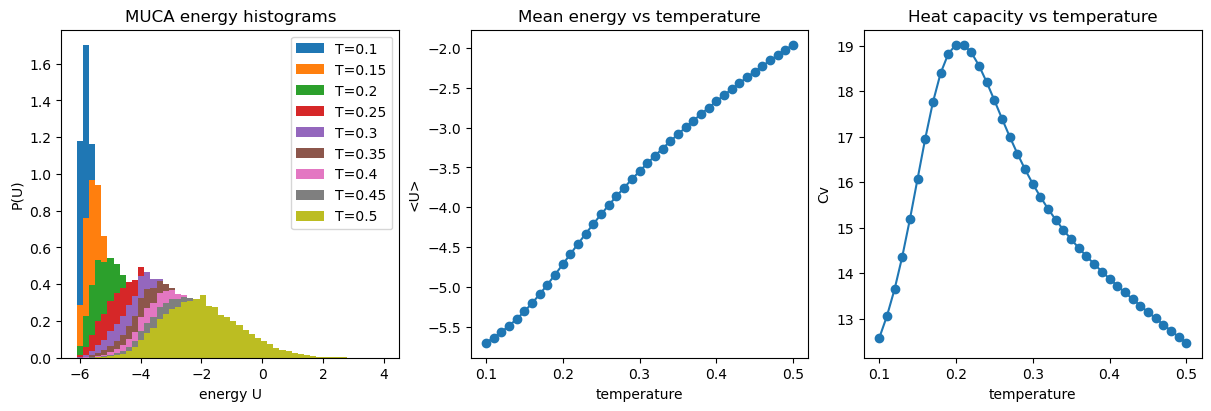

In [33]:
# Temperatures of interest - we can make this as fine as we like since each temperature no longer requires
# a new simulation to sample.
#temperatures = np.arange(0.1, 0.55, 0.05)
temperatures = np.arange(0.1, 0.51, 0.01)

# Setup plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1.set_xlabel('energy U')
ax1.set_ylabel('P(U)')
ax1.set_title("MUCA energy histograms")

ax2.set_xlabel('temperature')
ax2.set_ylabel('<U>')
ax2.set_title('Mean energy vs temperature')  

ax3.set_xlabel('temperature')
ax3.set_ylabel('Cv')
ax3.set_title('Heat capacity vs temperature') 

# Initialise arrays 
mean_energies   = np.zeros(len(temperatures))
mean_errors     = np.zeros(len(temperatures))
heat_caps       = np.zeros(len(temperatures))
#heat_caps2      = np.zeros(len(temperatures))

# Loop over temperatures of interest
for itemp, new_temp in enumerate(temperatures):
    
    # Create histogram 
    prob, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, new_temp)

    # Only plot every 5th histogram to avoid crowding the axes
    if itemp%5 == 0:
        strlabel = "T={:1.2}".format(new_temp)
        ax1.bar(bins[:-1], prob, width=bin_width, align='edge', label=strlabel)
    
    # Mean energy
    mean_energy = np.dot(bin_edges[:-1]+0.5*bin_width, prob)/np.sum(prob)
    mean_energies[itemp] = mean_energy

    # Compute heat capacity using the histogram
    msq_dev = np.zeros(len(bin_edges)-1)
    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        msq_dev[ibin] = (bin_energy - mean_energies[itemp])**2
        
    heat_caps[itemp] = np.dot(msq_dev, prob)*bin_width/(new_temp**2) + (Ndims/2)*(Nbeads-1)


# Complete plots using data computed above
ax1.legend()
ax2.errorbar(temperatures, mean_energies,yerr=mean_errors, fmt='-o')
ax3.plot(temperatures, heat_caps, '-o', label='samples')
plt.show()

# Store heat_caps for comparison to alternative compuation below
hist_heat_caps = heat_caps

Note that we've lost the spurious peak at $T=0.1$ because we're now able to transition between different low energy coiled configurations of the polymer by going via higher energy states inaccessible at the lower temperature.

## Sample reweighting

This is all fine provided the only quanities I want to know at any temperature can be computed directly from the energy histogram. Any other quantities need to sampled during the MUCA run along with the corresponding microstate energy $U$ so that we can give them an appropriate weight at the new temperature and to remove the effect of the bias $V(U)$. 

In the above we've recorded samples of both energy $U$ and end-to-end distance $L$.

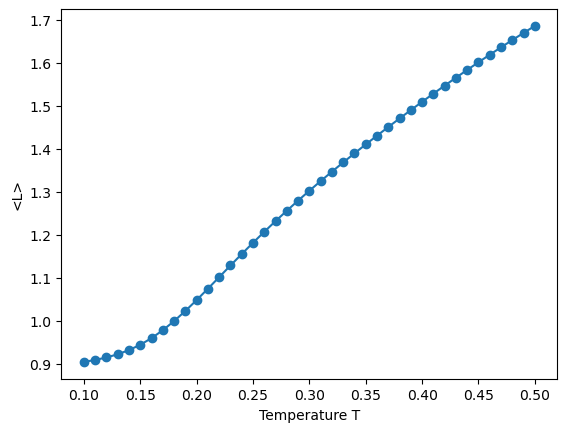

In [29]:
# Do something with the samples
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

# End to end distance as a function of temperature
temperatures = np.arange(0.1, 0.51, 0.01)

# Array of average end-to-end distances
mean_end2end = np.zeros(len(temperatures))

# Array of weights at the current temperature for each sample
weights = np.zeros(len(energy_samples))

# Loop over temperatures of interest
for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    for isamp, sample_energy in enumerate(energy_samples):

        # What energy bin does this sample lie in?
        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin] ; bias = old_bias[ibin]

        # With what weight should we count the sample of interest at the current temperature
        weights[isamp] = m.exp((bias+sample_energy)/temp)*m.exp(-sample_energy/new_temp)
    
    # Mean end to end distance is dot product of samples and weights
    mean_end2end[itemp] = np.dot(end2end_samples, weights)/np.sum(weights)

fig, ax = plt.subplots()
plt.plot(temperatures, mean_end2end,'o-')
ax.set_xlabel('Temperature T')
ax.set_ylabel('<L>')
plt.show()

For completeness, we can also weight each sample of energy individually to compute (e.g.) heat capacity without using the discretised energies at the centre of the histogram bin.

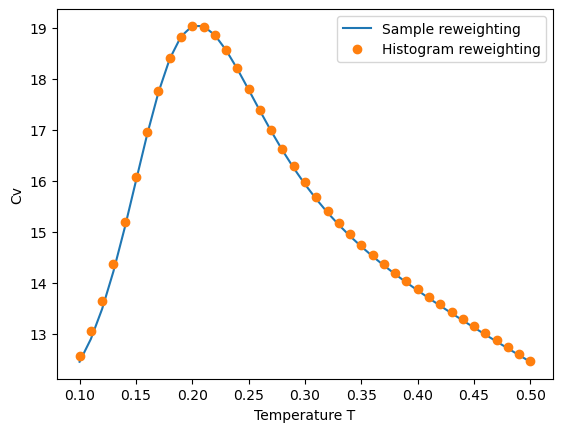

In [42]:
# Heat capacity as a function of temperature
temperatures = np.arange(0.1,0.51,0.01)

heat_cap = np.zeros(len(temperatures))

for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    # We use the bins only to determine the bias V at which the sample was generated
    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bias = old_bias[ibin]
        weights[isamp] = m.exp((bias+sample_energy)/temp)*m.exp(-sample_energy/new_temp)    

    mean_energy = np.dot(energy_samples, weights)/np.sum(weights)
    delta_energy_sq = [(energy - mean_energy)**2 for energy in energy_samples]
    mean_deltaE_sq = np.dot(delta_energy_sq ,weights)/np.sum(weights)
    
    heat_cap[itemp] = mean_deltaE_sq/(new_temp**2) + (Ndims/2)*(Nbeads-1)

# Plot and compare to that obtained by reweighting the histogram
fig, ax = plt.subplots()
plt.plot(temperatures, heat_cap,'-', label='Sample reweighting')
plt.plot(temperatures, hist_heat_caps,'o', label='Histogram reweighting')
ax.set_xlabel('Temperature T')
ax.set_ylabel('Cv')
ax.legend()
plt.show()